In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
sys.path.append('./data/')
sys.path.append('./models/')

from baseline import *
import pickle
with open('./data/dict_data_final.pkl', 'rb') as f:
    data = pickle.load(f)

__, y = data['Beneixama']
x = pd.read_csv('data_beneixama.csv', index_col=0)
x['Train'] = __['Train'].values

# Parameters

In [20]:
list_P = [
    [0, 0.1, 0.5, 0.9, 1.01],
    [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.01],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.01],
]
list_C = [1, 1.5, 2, 2.5, 3, 4, 5]

# Compute de table

Vamos a calcular la tabla donde se recogen las principales métricas de precisión de nuestro modelo. Todas ellas serán balanceadas para ajustar el desequilibrio entre las clases.

In [3]:
w = torch.where(
    torch.from_numpy(y[:, :, -1] == 0),
    torch.from_numpy(y[:, :, -1] != 0).sum(),
    torch.from_numpy(y[:, :, -1] == 0).sum()
)/(257**2)

##### loss & metrics #####

loss = nn.BCELoss(weight=w.flatten().reshape(-1, 1))
y_t = torch.tensor(y, dtype=torch.float32)

In [4]:
Y = (y[:, :, -1] != 0)*1

In [5]:
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score

In [6]:
data_loss = np.zeros((len(list_P), len(list_C), 5))
for i, part in enumerate(list_P):
    for j, c in enumerate(list_C):

        print('Part: ', part, ' Div: ', c)

        grid = Grid(x=x, y=y)
        grid.initialize(part=part, div=c)
        grid.submatrix()
        grid.enlargement_process()
        grid.montecarlo(n_it=100)

        X = (grid.X[:, :, -1].numpy() != 0)*1

        cmat = confusion_matrix(Y.flatten(), X.flatten(), normalize='true')

        fp = cmat[0, 1]
        fn = cmat[1, 0]

        acc = balanced_accuracy_score(Y.flatten(), X.flatten())
        f1 = f1_score(Y.flatten(), X.flatten(), average='weighted')

        l_b = loss(
            torch.stack(
                    [grid.X0[:, :, -1].flatten(), 1 - grid.X0[:, :, -1].flatten()], 
                    dim=-1
                ).float(),
                torch.stack(
                    [((y_t[:, :, -1] == 0)*1).flatten(), ((y_t[:, :, -1] != 0)*1).flatten()],
                    dim=-1
                ).float()
        ).clone().item()
        
        print('fp: ', fp, ' fn: ', fn)
        print(' acc: ', acc, ' f1: ', f1, ' loss: ', l_b)

        data_loss[i, j, :] = [fp, fn, acc, f1, l_b]

Part:  [0, 0.1, 0.5, 0.9, 1.01]  Div:  1
fp:  0.015919966549486627  fn:  0.39227642276422764
 acc:  0.7959018053431428  f1:  0.9772331875209709  loss:  0.8453402519226074
Part:  [0, 0.1, 0.5, 0.9, 1.01]  Div:  1.5
fp:  0.013519582488036795  fn:  0.3943089430894309
 acc:  0.7960857372112662  f1:  0.978934380264774  loss:  0.7733964920043945
Part:  [0, 0.1, 0.5, 0.9, 1.01]  Div:  2
fp:  0.009198891177427098  fn:  0.4518970189701897
 acc:  0.7694520449261916  f1:  0.9806714592989331  loss:  0.7789738774299622
Part:  [0, 0.1, 0.5, 0.9, 1.01]  Div:  2.5
fp:  0.0062719712573366575  fn:  0.5121951219512195
 acc:  0.7407664533957219  f1:  0.9812599141206148  loss:  0.8464807271957397
Part:  [0, 0.1, 0.5, 0.9, 1.01]  Div:  3
fp:  0.004429095752094529  fn:  0.5609756097560976
 acc:  0.717297647245904  f1:  0.9812723981961506  loss:  0.9506329298019409
Part:  [0, 0.1, 0.5, 0.9, 1.01]  Div:  4
fp:  0.00235392501509919  fn:  0.6409214092140921
 acc:  0.6783623328854043  f1:  0.9803685037670078  los

KeyboardInterrupt: 

In [ ]:
data_loss[2, :, :]

array([[0.24284144, 0.16124661, 0.79795598, 0.84378451, 0.86600477],
       [0.1938736 , 0.09349593, 0.85631523, 0.87557823, 0.37220591],
       [0.08062193, 0.06300813, 0.92818497, 0.94354939, 0.12732276],
       [0.03368281, 0.22560976, 0.87035372, 0.96904844, 0.2252672 ],
       [0.01663234, 0.36653117, 0.80841825, 0.97736761, 0.35009986],
       [0.00565252, 0.54268293, 0.72583228, 0.98084654, 0.68283933],
       [0.00250879, 0.64227642, 0.67760739, 0.98019589, 0.93666625]])

In [ ]:
data_loss_formatted = np.around(data_loss*100, decimals=4)

In [ ]:
data_loss_formatted[2, :, :]

array([[24.2841, 16.1247, 79.7956, 84.3785, 86.6005],
       [19.3874,  9.3496, 85.6315, 87.5578, 37.2206],
       [ 8.0622,  6.3008, 92.8185, 94.3549, 12.7323],
       [ 3.3683, 22.561 , 87.0354, 96.9048, 22.5267],
       [ 1.6632, 36.6531, 80.8418, 97.7368, 35.01  ],
       [ 0.5653, 54.2683, 72.5832, 98.0847, 68.2839],
       [ 0.2509, 64.2276, 67.7607, 98.0196, 93.6666]])

In [ ]:
data_loss[2, :, :].mean(axis=0)

array([0.08225906, 0.29926442, 0.80923826, 0.93862437, 0.50862944])

In [ ]:
df0 = pd.DataFrame(data_loss_formatted[0, :, :])
df0.columns = ['fp', 'fn', 'acc', 'f1', 'loss']

df_formatted = df0.round(2)

# Genera la tabla de LaTeX utilizando el método to_latex()
latex_table = df_formatted.to_latex(index=False, header=False)
print(latex_table)

\begin{tabular}{rrrrr}
\toprule
1.59 & 39.23 & 79.59 & 97.72 &  84.53 \\
1.35 & 39.43 & 79.61 & 97.89 &  77.34 \\
0.92 & 45.19 & 76.95 & 98.07 &  77.90 \\
0.63 & 51.22 & 74.08 & 98.13 &  84.65 \\
0.44 & 56.10 & 71.73 & 98.13 &  95.06 \\
0.24 & 64.09 & 67.84 & 98.04 & 108.07 \\
0.15 & 69.58 & 65.13 & 97.91 & 115.79 \\
\bottomrule
\end{tabular}



In [ ]:
df0.mean(axis=0).values.flatten()

array([ 0.76017143, 52.11961429, 73.5601    , 97.98365714, 91.90577143])

In [ ]:
df1 = pd.DataFrame(data_loss_formatted[1, :, :])
df1.columns = ['fp', 'fn', 'acc', 'f1', 'loss']

df_formatted = df1.round(2)

# Genera la tabla de LaTeX utilizando el método to_latex()
latex_table = df_formatted.to_latex(index=False, header=False)
print(latex_table)

\begin{tabular}{rrrrr}
\toprule
6.23 & 14.97 & 89.40 & 95.29 &  41.70 \\
5.54 & 11.99 & 91.23 & 95.76 &  18.54 \\
3.40 & 21.61 & 87.49 & 96.90 &  23.51 \\
1.97 & 33.13 & 82.45 & 97.60 &  43.82 \\
1.19 & 42.34 & 78.23 & 97.94 &  62.70 \\
0.49 & 55.96 & 71.78 & 98.10 &  83.84 \\
0.22 & 66.06 & 66.86 & 97.98 & 105.22 \\
\bottomrule
\end{tabular}



In [ ]:
df1.mean(axis=0).values.flatten()

array([ 2.72051429, 35.15294286, 81.0633    , 97.08091429, 54.18957143])

In [ ]:
df2 = pd.DataFrame(data_loss_formatted[2, :, :])
df2.columns = ['fp', 'fn', 'acc', 'f1', 'loss']

df_formatted = df2.round(2)

# Genera la tabla de LaTeX utilizando el método to_latex()
latex_table = df_formatted.to_latex(index=False, header=False)
print(latex_table)

\begin{tabular}{rrrrr}
\toprule
24.28 & 16.12 & 79.80 & 84.38 & 86.60 \\
19.39 &  9.35 & 85.63 & 87.56 & 37.22 \\
 8.06 &  6.30 & 92.82 & 94.35 & 12.73 \\
 3.37 & 22.56 & 87.04 & 96.90 & 22.53 \\
 1.66 & 36.65 & 80.84 & 97.74 & 35.01 \\
 0.57 & 54.27 & 72.58 & 98.08 & 68.28 \\
 0.25 & 64.23 & 67.76 & 98.02 & 93.67 \\
\bottomrule
\end{tabular}



In [ ]:
df2.mean(axis=0).values.round(2).flatten()

array([ 8.23, 29.93, 80.92, 93.86, 50.86])

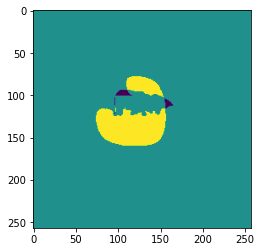

In [ ]:
part = list_P[1]
c = list_C[1]


grid = Grid(x=x, y=y)
grid.initialize(part=part, div=c)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plt.imshow(X-Y)

<AxesSubplot:>

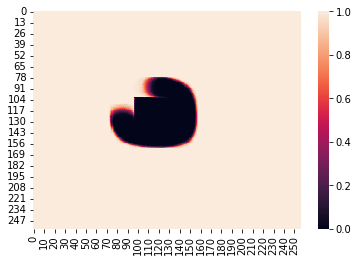

In [ ]:
sns.heatmap(grid.X0[:, :, -1].numpy())

# 2. Calculamos todas y cada una de las métricas

In [7]:
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score, fbeta_score, accuracy_score, cohen_kappa_score, matthews_corrcoef

In [8]:
Y = (y[:, :, -1] != 0)*1
columnas = ['fp', 'fn', 'acc_b', 'acc', 'f0', 'f1', 'f2', 'kappa', 'mcc']

In [9]:
data_metrics = np.zeros((len(list_P), len(list_C), 9))
for i, part in enumerate(list_P):
    for j, c in enumerate(list_C):
        
        grid = Grid(x=x, y=y)
        grid.initialize(part=part, div=c)
        grid.submatrix()
        grid.enlargement_process()
        grid.montecarlo(n_it=100)

        X = (grid.X[:, :, -1].numpy() != 0)*1

        cmat = confusion_matrix(Y.flatten(), X.flatten(), normalize='true')*100
        fp = cmat[0, 1]
        fn = cmat[1, 0]
        acc_b = balanced_accuracy_score(Y.flatten(), X.flatten())*100
        acc = accuracy_score(Y.flatten(), X.flatten())*100
        f0 = fbeta_score(Y.flatten(), X.flatten(), beta=0.5)*100
        f1 = f1_score(Y.flatten(), X.flatten())*100
        f2 = fbeta_score(Y.flatten(), X.flatten(), beta=2)*100
        kappa = cohen_kappa_score(Y.flatten(), X.flatten())*100
        mcc = matthews_corrcoef(Y.flatten(), X.flatten())*100

        data_metrics[i, j, :] = [fp, fn, acc_b, acc, f0, f1, f2, kappa, mcc]

    df = pd.DataFrame(data_metrics[i, :, :], columns=columnas).round(2)
    df.to_csv('tables\metrics_part_' + str(i) + '.csv', index=False)

<AxesSubplot:>

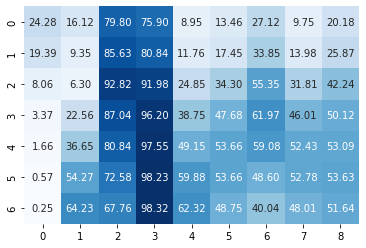

In [10]:
sns.heatmap(df.values, annot=True, fmt='.2f', cmap='Blues', cbar=False)

In [11]:
fbeta_score(Y.flatten(), X.flatten(), beta=0.5)

0.623229461756374

# Evolución

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


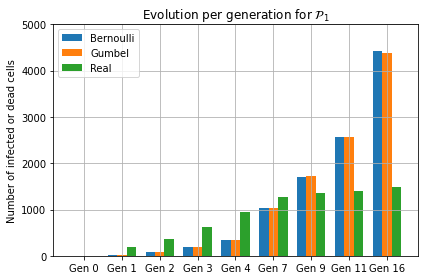

In [25]:
grid = Grid(x=x, y=y)
grid.initialize(part=list_P[1], div=list_C[1])
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

grid_g = Grid(x=x, y=y, mode='gumbel')
grid_g.initialize(part=list_P[1], div=list_C[1])
grid_g.submatrix()
grid_g.enlargement_process()
grid_g.montecarlo(n_it=100)

sus_X = np.array([(grid.X[:, :, i] != 0).sum().item() for i in range(grid.X.shape[2])])
sus_X_g = np.array([(grid_g.X[:, :, i] != 0).sum().item() for i in range(grid_g.X.shape[2])])
sus_y = np.array([(grid.y[:, :, i] != 0).sum().item() for i in range(grid.y.shape[2])])

abs_X = range(len(sus_X))
abs_y = np.argwhere(x.Train.values == True).flatten()

mode = ['Gen ' + str(i) for i in abs_y]
values = {
    'Bernoulli': sus_X[abs_y],
    'Gumbel': sus_X_g[abs_y],
    'Real': sus_y
}

x_ = np.arange(len(mode))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x_ + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of infected or dead cells')
ax.set_title('Evolution per generation for ' + r'$\mathcal{P}_1$')
ax.set_xticks(x_ + width, mode)
ax.legend(loc='upper left')
ax.set_ylim(0, 5000)
ax.grid()

fig.tight_layout()
fig.savefig('figures/evolution_per_generation_p1.png', dpi=1000)
fig.savefig('figures/evolution_per_generation_p1.eps', dpi=1000)

plt.show()

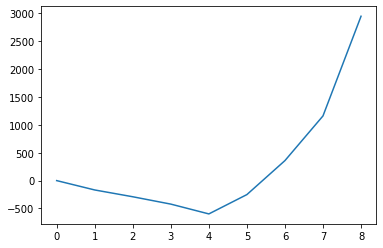

In [13]:
plt.plot(sus_X[abs_y] - sus_y)

In [14]:
sus_X[abs_y] - sus_y

array([   0, -168, -290, -422, -598, -251,  359, 1161, 2950])

In [15]:
grid = Grid(x=x, y=y)
grid.initialize(part=list_P[2], div=2.3)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

grid_g = Grid(x=x, y=y, mode='gumbel')
grid_g.initialize(part=list_P[2], div=2.3)
grid_g.submatrix()
grid_g.enlargement_process()
grid_g.montecarlo(n_it=100)

sus_X = np.array([(grid.X[:, :, i] != 0).sum().item() for i in range(grid.X.shape[2])])
sus_X_g = np.array([(grid_g.X[:, :, i] != 0).sum().item() for i in range(grid_g.X.shape[2])])
sus_y = np.array([(grid.y[:, :, i] != 0).sum().item() for i in range(grid.y.shape[2])])

abs_X = range(len(sus_X))
abs_y = np.argwhere(x.Train.values == True).flatten()

mode = ['Gen ' + str(i) for i in abs_y]
values = {
    'Bernoulli': sus_X[abs_y],
    'Gumbel': sus_X_g[abs_y],
    'Real': sus_y
}

x_ = np.arange(len(mode))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0


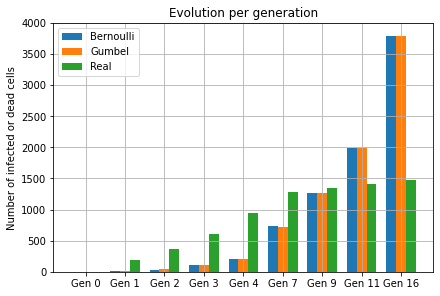

In [16]:
fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x_ + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of infected or dead cells')
ax.set_title('Evolution per generation')
ax.set_xticks(x_ + width, mode)
ax.legend(loc='upper left')
ax.set_ylim(0, 4000)
ax.grid()

plt.show()

In [17]:
sus_X[abs_y] - sus_y

array([   0, -177, -338, -507, -729, -550,  -85,  575, 2311])

# Dataframes

In [18]:
df1 = pd.read_csv('metrics_part_0.csv')
df2 = pd.read_csv('metrics_part_1.csv')
df3 = pd.read_csv('metrics_part_2.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'metrics_part_0.csv'

In [ ]:
latex_table1 = df1.to_latex(index=False, header=False)
latex_table2 = df2.to_latex(index=False, header=False)
latex_table3 = df3.to_latex(index=False, header=False)

In [ ]:
print(latex_table1)

\begin{tabular}{rrrrrrrrr}
\toprule
1.59 & 39.23 & 79.59 & 97.57 & 48.88 & 52.75 & 57.29 & 51.52 & 52.00 \\
1.35 & 39.43 & 79.61 & 97.80 & 52.32 & 55.13 & 58.27 & 54.01 & 54.24 \\
0.92 & 45.19 & 76.95 & 98.09 & 57.07 & 56.20 & 55.36 & 55.22 & 55.24 \\
0.63 & 51.22 & 74.08 & 98.24 & 60.24 & 55.36 & 51.22 & 54.48 & 55.01 \\
0.44 & 56.10 & 71.73 & 98.31 & 62.16 & 53.78 & 47.38 & 52.96 & 54.41 \\
0.24 & 64.09 & 67.84 & 98.34 & 63.04 & 49.12 & 40.24 & 48.39 & 52.16 \\
0.15 & 69.58 & 65.13 & 98.30 & 61.27 & 44.39 & 34.80 & 43.71 & 49.37 \\
\bottomrule
\end{tabular}



In [ ]:
df1 = df1.iloc[:-2]
df2 = df2.iloc[:-2]
df3 = df3.iloc[:-2]

array([ 0.99, 46.23, 76.39, 98.  , 56.13, 54.64, 53.9 , 53.64, 54.18])

In [ ]:
print(df3.mean(axis=0).round(2).to_latex(index=False, header=False))

\begin{tabular}{r}
\toprule
11.35 \\
18.20 \\
85.23 \\
88.49 \\
26.69 \\
33.31 \\
47.47 \\
30.80 \\
38.30 \\
\bottomrule
\end{tabular}



In [ ]:
print(df3.to_latex(index=False, header=False))

\begin{tabular}{rrrrrrrrr}
\toprule
24.28 & 16.12 & 79.80 & 75.90 &  8.95 & 13.46 & 27.12 &  9.75 & 20.18 \\
19.39 &  9.35 & 85.63 & 80.84 & 11.76 & 17.45 & 33.85 & 13.98 & 25.87 \\
 8.06 &  6.30 & 92.82 & 91.98 & 24.85 & 34.30 & 55.35 & 31.81 & 42.24 \\
 3.37 & 22.56 & 87.04 & 96.20 & 38.75 & 47.68 & 61.97 & 46.01 & 50.12 \\
 1.66 & 36.65 & 80.84 & 97.55 & 49.15 & 53.66 & 59.08 & 52.43 & 53.09 \\
\bottomrule
\end{tabular}



In [ ]:
df3

,fp,fn,acc_b,acc,f0,f1,f2,kappa,mcc
0,24.28,16.12,79.80,75.90,8.95,13.46,27.12,9.75,20.18
1,19.39,9.35,85.63,80.84,11.76,17.45,33.85,13.98,25.87
2,8.06,6.30,92.82,91.98,24.85,34.30,55.35,31.81,42.24
3,3.37,22.56,87.04,96.20,38.75,47.68,61.97,46.01,50.12
4,1.66,36.65,80.84,97.55,49.15,53.66,59.08,52.43,53.09
